<a href="https://colab.research.google.com/github/kristina-skoptsova/image_processing/blob/main/spz2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модуль 2. Классификация изображений


In [27]:

!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [13]:
!git clone https://github.com/kristina-skoptsova/image_processing

Cloning into 'image_processing'...
remote: Enumerating objects: 2324, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 2324 (delta 24), reused 155 (delta 16), pack-reused 2152 (from 1)
Receiving objects: 100% (2324/2324), 129.28 MiB | 22.49 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (2889/2889), done.


In [25]:
%cd image_processing

/content/image_processing


## Сопоставление изображений


### Алгоритмы сопоставления изображений

Для реализации алгоритма классификации изображений, я предложу вам пример кода, использующий библиотеку tensorflow и keras. В этом примере мы будем использовать предварительно обученную модель MobileNetV2 для классификации изображений.

Прежде всего, убедитесь, что у вас установлены tensorflow и keras


In [2]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import (
    preprocess_input,
    decode_predictions,
)
from tensorflow.keras.preprocessing import image

# Загрузка предварительно обученной модели MobileNetV2
model = MobileNetV2(weights="imagenet")


def classify_image(img_path):
    # Загрузка изображения, его предварительная обработка и расширение размерностей
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    preprocessed_image = preprocess_input(img_array_expanded_dims)

    # Прогнозирование и декодирование предсказаний
    predictions = model.predict(preprocessed_image)
    results = decode_predictions(predictions, top=3)[0]

    # Вывод результатов
    for i, (imagenet_id, label, score) in enumerate(results):
        print(f"{i + 1}: {label} ({score*100:.2f}%)")


# Пример использования
img_path = "/content/texture_01.jpg"
classify_image(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1: fur_coat (10.58%)
2: bittern (2.80%)
3: tiger (1.93%)


### Построение мозаики из изображений

Для построения мозаики изображений на Python, можно использовать библиотеку PIL (Python Imaging Library), которая теперь доступна как Pillow. Ниже приведен пример кода, который создает мозаику из нескольких изображений. Допустим, у нас есть четыре изображения, и мы хотим их объединить в одно большое изображение-мозаику в формате 2x2.

Прежде всего, убедитесь, что у вас установлена библиотека Pillow


In [5]:
from PIL import Image


def crop_to_square(img, size):
    """
    Обрезка изображения до квадратной формы по центру.
    """
    # Определение текущих размеров
    width, height = img.size

    # Определение размера для обрезки
    new_size = min(width, height, size)

    # Вычисление координат для обрезки
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2

    # Обрезка и возврат изображения
    img = img.crop((left, top, right, bottom))
    return img.resize((size, size), Image.Resampling.LANCZOS)


# Пути к изображениям, которые будут включены в мозаику
image_paths = ["/content/image1.jpg", "/content/image2.jpg", "/content/image3.jpg", "/content/image4.jpg"]

# Открытие изображений и их сохранение в список
images = [Image.open(f"{x}") for x in image_paths]

# Определение минимального размера среди всех изображений
min_size = min(min(img.size) for img in images)

# Обрезка изображений до квадратов и изменение их размера
squared_images = [crop_to_square(img, min_size) for img in images]

# Создание нового пустого изображения для мозаики
mosaic_size = (min_size * 2, min_size * 2)
mosaic_image = Image.new("RGB", mosaic_size, (255, 255, 255))

# Размещение изображений в мозаике
positions = [(0, 0), (min_size, 0), (0, min_size), (min_size, min_size)]
for img, pos in zip(squared_images, positions):
    mosaic_image.paste(img, pos)

# Сохранение и показ мозаики
mosaic_image.save("/content/mosaic.jpg")
mosaic_image.show()

### Построение панорамных изображений


In [6]:
import cv2
import numpy as np


def create_panorama(image1_path, image2_path, output_path="panorama.jpg"):
    # Загружаем изображения
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # Инициализируем ORB детектор
    orb = cv2.ORB_create()

    # Находим ключевые точки и дескрипторы с помощью ORB
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

    # Создаем объект BFMatcher и совершаем сопоставление дескрипторов
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Сортируем сопоставления по расстоянию (лучшие сопоставления первые)
    matches = sorted(matches, key=lambda x: x.distance)

    # Извлекаем координаты соответствующих ключевых точек для сопоставленных дескрипторов
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Находим матрицу гомографии
    H, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Применяем преобразование гомографии к изображению 1
    height, width, channels = image2.shape
    panorama = cv2.warpPerspective(image1, H, (width * 2, height))

    # Копируем изображение 2 в панорамное изображение
    panorama[0 : image2.shape[0], 0 : image2.shape[1]] = image2

    # Сохраняем панорамное изображение
    cv2.imwrite(output_path, panorama)


# Пример использования:
create_panorama("/content/panorama02.jpg", "/content/panorama01.jpg", "/content/panorama01.jpg")

## Распознавание лиц


In [8]:
pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566164 sha256=2d8653ae8cfea1812f767ac8d1464c043a4fa94e6b40fce3940bfb2a99f7034a
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


Найдено лиц: 1


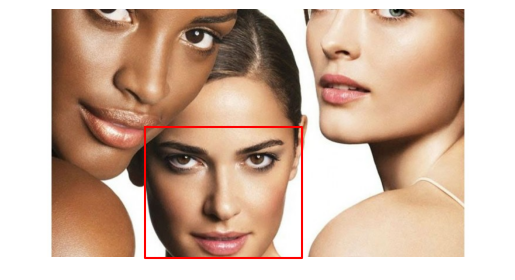

In [11]:
import face_recognition
import matplotlib.pyplot as plt

face = ["3faces.jpg", "manyfaces.jpg"]
# Загрузка изображения
image_path = f"/content/faces/{face[0]}"
image = face_recognition.load_image_file(image_path)

# Нахождение лиц на изображении
face_locations = face_recognition.face_locations(image)

# Вывод результатов
print(f"Найдено лиц: {len(face_locations)}")
plt.imshow(image)
for face_location in face_locations:
    top, right, bottom, left = face_location
    plt.plot([left, right, right, left, left], [top, top, bottom, bottom, top], "r-")
plt.axis("off")
plt.show()

In [14]:
from PIL import Image
import os


def resize_image(input_image_path, output_image_path, target_size):
    with Image.open(input_image_path) as image:
        original_width, original_height = image.size
        max_dimension = max(original_width, original_height)
        scale = target_size / max_dimension
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)

        resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
        resized_image.save(output_image_path)


def process_images_folder(input_folder, output_folder, target_size):
    # Получение абсолютных путей папок
    script_dir = os.getcwd()
    abs_input_folder = os.path.join(script_dir, input_folder)
    abs_output_folder = os.path.join(script_dir, output_folder)

    if not os.path.exists(abs_output_folder):
        os.makedirs(abs_output_folder)

    for filename in os.listdir(abs_input_folder):
        input_image_path = os.path.join(abs_input_folder, filename)
        if os.path.isfile(input_image_path):
            output_image_path = os.path.join(abs_output_folder, filename)
            try:
                resize_image(input_image_path, output_image_path, target_size)
                print(f"Image {filename} resized and saved to {output_folder}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")


# Пути к папкам относительно скрипта
input_folder = "/content/image_processing/data/plibrary/src"
output_folder = "/content/image_processing/data/plibrary/resampled"
target_size = 800  # Целевой размер для большей стороны изображения

# Обработка всех изображений в папке
process_images_folder(input_folder, output_folder, target_size)

Image img_16.jpg resized and saved to /content/image_processing/data/plibrary/resampled
Image img_06.jpg resized and saved to /content/image_processing/data/plibrary/resampled
Image img_19.jpg resized and saved to /content/image_processing/data/plibrary/resampled
Image img_11.jpg resized and saved to /content/image_processing/data/plibrary/resampled
Image img_25.jpg resized and saved to /content/image_processing/data/plibrary/resampled
Image img_08.jpg resized and saved to /content/image_processing/data/plibrary/resampled
Error processing file README.md: cannot identify image file '/content/image_processing/data/plibrary/src/README.md'
Image img_09.jpg resized and saved to /content/image_processing/data/plibrary/resampled
Image img_12.jpg resized and saved to /content/image_processing/data/plibrary/resampled
Image img_05.jpg resized and saved to /content/image_processing/data/plibrary/resampled
Image img_22.jpg resized and saved to /content/image_processing/data/plibrary/resampled
Imag

In [16]:
import face_recognition
import os
from shutil import copy2


def filter_images_with_faces(source_folder, destination_folder):
    # Создание папки назначения, если она не существует
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Перебор всех файлов в исходной папке
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)

        # Убедитесь, что это файл и он имеет расширение изображения
        if os.path.isfile(file_path) and filename.lower().endswith((".png", ".jpg", ".jpeg")):
            try:
                # Загрузка изображения и поиск лиц
                image = face_recognition.load_image_file(file_path)
                face_locations = face_recognition.face_locations(image)

                # Если лица обнаружены, копировать файл в папку назначения
                if len(face_locations) > 0:
                    destination_path = os.path.join(destination_folder, filename)
                    copy2(file_path, destination_path)
                    print(f"Image {filename} has faces and was copied.")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")


# Задайте пути к папкам
script_dir = os.getcwd()
source_folder = os.path.join(script_dir, "/content/image_processing/data/plibrary/resampled")
destination_folder = os.path.join(script_dir, "/content/image_processing/data/plibrary/justfaces")

# Фильтрация изображений
filter_images_with_faces(source_folder, destination_folder)

Image img_16.jpg has faces and was copied.
Image img_06.jpg has faces and was copied.
Image img_09.jpg has faces and was copied.
Image img_22.jpg has faces and was copied.
Image img_07.jpg has faces and was copied.
Image img_10.jpg has faces and was copied.
Image img_24.jpg has faces and was copied.
Image img_23.jpg has faces and was copied.


In [17]:
import face_recognition
import os
import shutil


def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


def find_face_encodings(image_path):
    image = face_recognition.load_image_file(image_path)
    return face_recognition.face_encodings(image)


def are_faces_same(face_encoding, known_faces):
    # Если нет известных лиц, не сравниваем
    if len(known_faces) == 0:
        return -1
    distances = face_recognition.face_distance(known_faces, face_encoding)
    best_match_index = distances.argmin()
    if distances[best_match_index] < 0.6:
        return best_match_index
    else:
        return -1


source_folder = os.path.join(script_dir, "/content/image_processing/data/plibrary/justfaces")
destination_folder = os.path.join(script_dir, "/content/image_processing/data/plibrary/grouped")
create_directory_if_not_exists(destination_folder)

known_faces = []
face_folders = []

# Перебор всех файлов в исходной папке
for filename in os.listdir(source_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(source_folder, filename)
        image_encodings = find_face_encodings(image_path)

        for encoding in image_encodings:
            match_index = are_faces_same(encoding, known_faces)

            if match_index != -1:
                # Лицо совпадает с известным, копируем в соответствующую папку
                shutil.copy2(image_path, face_folders[match_index])
            else:
                # Новое лицо, создаем для него папку
                new_folder_path = os.path.join(destination_folder, f"person_{len(known_faces)}")
                create_directory_if_not_exists(new_folder_path)
                shutil.copy2(image_path, new_folder_path)

                # Добавляем лицо и папку в известные
                known_faces.append(encoding)
                face_folders.append(new_folder_path)

print(f"Фотографии были сгруппированы по {len(known_faces)} лицам.")

Фотографии были сгруппированы по 4 лицам.


## Коллекции для обучения


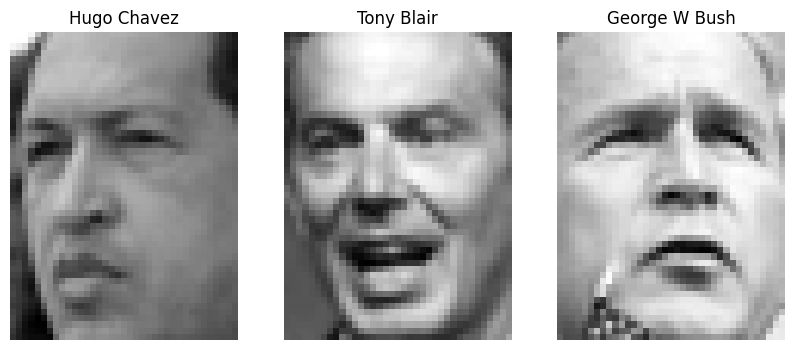

In [18]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

# Загрузка набора данных LFW
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Получение ссылок на изображения и их метки
images = lfw_people.images
target_names = lfw_people.target_names
targets = lfw_people.target

# Отображение первых 3 изображений
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(images[i], cmap="gray")
    ax[i].set_title(target_names[targets[i]])
    ax[i].axis("off")
plt.show()

## Квантование многомерных признаков

КМП - это процесс преобразования непрерывных или многомерных признаков в дискретные значения, часто используемый для уменьшения количества различных признаков и упрощения алгоритмов машинного обучения, в том числе в контексте классификации изображений и поиска похожих изображений.

В контексте классификации изображений и поиска похожих изображений, одним из распространенных подходов является использование векторов признаков, извлеченных из изображений с помощью предварительно обученных моделей глубокого обучения (например, сетей на основе архитектуры CNN). Квантование этих векторов признаков позволяет сократить объем хранимых данных и ускорить процесс сравнения изображений.

В качестве примера, давайте рассмотрим использование предварительно обученной модели CNN для извлечения признаков из изображений и их последующее квантование с помощью алгоритма K-средних (K-means). Затем мы можем использовать эти квантованные признаки для поиска похожих изображений.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Cluster 0 contains 2 images.


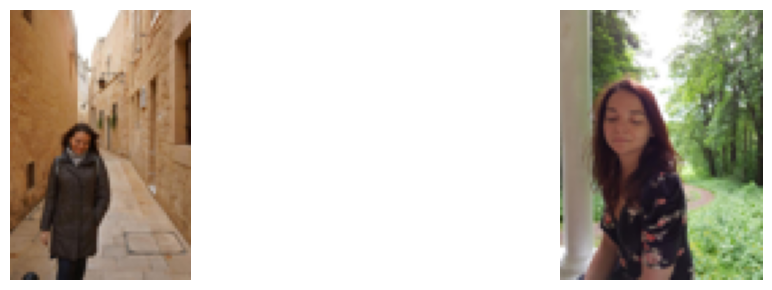

Cluster 2 contains 3 images.


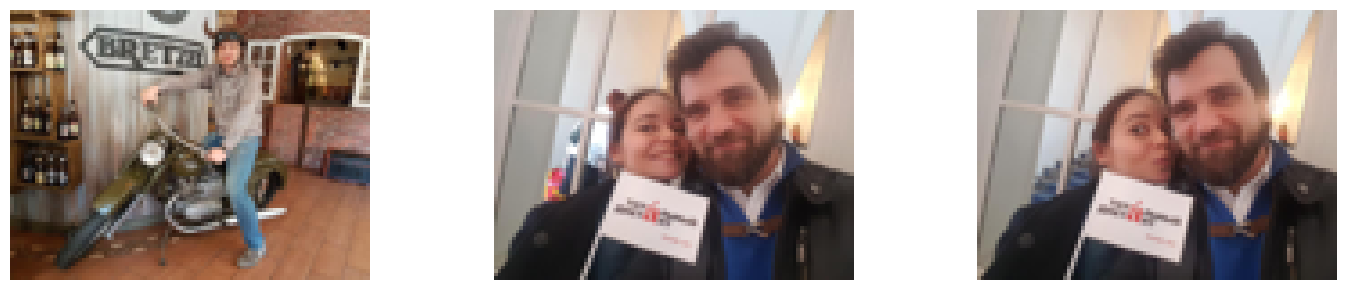

Cluster 1 contains 3 images.


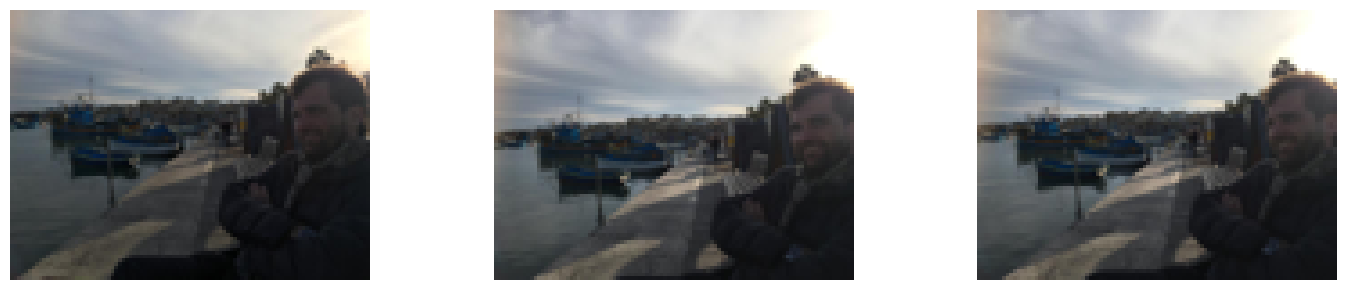

In [20]:
import os
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans

# Загрузка предварительно обученной модели ResNet50 без верхнего слоя
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
model = Model(inputs=base_model.input, outputs=base_model.output)


def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    return features.flatten()


def get_features_from_folder(folder_path):
    features_list = []
    images_paths = []
    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith(("png", "jpg", "jpeg")):
            img_path = os.path.join(folder_path, img_name)
            features = extract_features(img_path)
            features_list.append(features)
            images_paths.append(img_path)
    return features_list, images_paths


# Извлекаем признаки из всех изображений в папке
folder_path = os.path.join(script_dir, "/content/image_processing/data/plibrary/justfaces")
features_list, images_paths = get_features_from_folder(folder_path)

# Применяем K-средние для квантования признаков
num_clusters = 3  # Примерное количество ожидаемых групп
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features_list)

# Находим индекс центроида для каждого изображения
labels = kmeans.labels_

# Группировка изображений по кластерам
clustered_images = {}
for i, label in enumerate(labels):
    clustered_images.setdefault(label, []).append(images_paths[i])

# Вывод результатов группировки
""" for cluster_id, images in clustered_images.items():
    print(f"Cluster {cluster_id}:")
    for img_path in images:
        print(f" - {img_path}") """
# Выведем на экран
import matplotlib.pyplot as plt
from PIL import Image


def create_thumbnail(image_path, thumbnail_size=(100, 100)):
    with Image.open(image_path) as img:
        img.thumbnail(thumbnail_size)
        return img


def display_clustered_images(clustered_images, images_per_row=5):
    for cluster_id, images in clustered_images.items():
        print(f"Cluster {cluster_id} contains {len(images)} images.")
        num_rows = int(np.ceil(len(images) / images_per_row))
        num_cols = min(images_per_row, len(images))

        if len(images) == 1:
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
            axs = np.array([[axs]])  # Обеспечиваем 2D массив для единообразия
        else:
            fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3 * num_rows))
            axs = np.atleast_2d(axs)  # Убеждаемся, что axs всегда 2D массив

        # Преобразуем axs в 1D массив для упрощения итерации
        axs_flat = axs.ravel()

        for ax, img_path in zip(axs_flat, images):
            thumbnail = create_thumbnail(img_path)
            ax.imshow(thumbnail)
            ax.axis("off")

        # Скрываем пустые ячейки
        for ax in axs_flat[len(images) :]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()


# Отображаем изображения по кластерам
display_clustered_images(clustered_images)

### Извлечение признаков с помощью Пространственной Пирамиды

Для классификации изображений с использованием пространственной пирамиды, мы адаптируем предыдущий алгоритм, добавив этап создания пространственной пирамиды изображений перед кластеризацией с помощью K-средних. Это позволит нам учитывать локальные признаки на разных масштабах, что может улучшить точность классификации.


In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np


def extract_pyramid_features(img_path, model, levels=[1, 2, 4]):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Исходные размеры изображения
    base_height, base_width = img_array.shape[1:3]

    features = []
    for level in levels:
        for y in range(level):
            for x in range(level):
                # Вычисление координат области для текущего уровня
                width = base_width // level
                height = base_height // level
                x_start = x * width
                y_start = y * height

                # Вырезаем часть изображения и извлекаем признаки
                img_crop = img_array[:, y_start : y_start + height, x_start : x_start + width, :]
                crop_features = model.predict(img_crop)
                features.append(crop_features.flatten())

    # Объединение признаков со всех уровней
    final_features = np.concatenate(features)
    return final_features


# Загрузка модели
model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# Пример извлечения признаков
img_path = "/content/image_processing/data/plibrary/justfaces/img_09.jpg"
features = extract_pyramid_features(img_path, model)

print(f"Извлеченные признаки: {features.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Извлеченные признаки: (43008,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Cluster 0 contains 2 images.


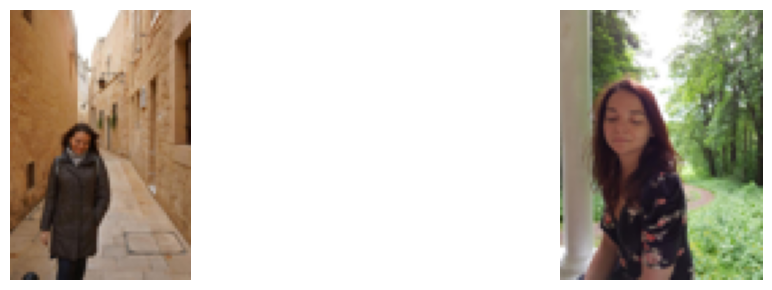

Cluster 2 contains 3 images.


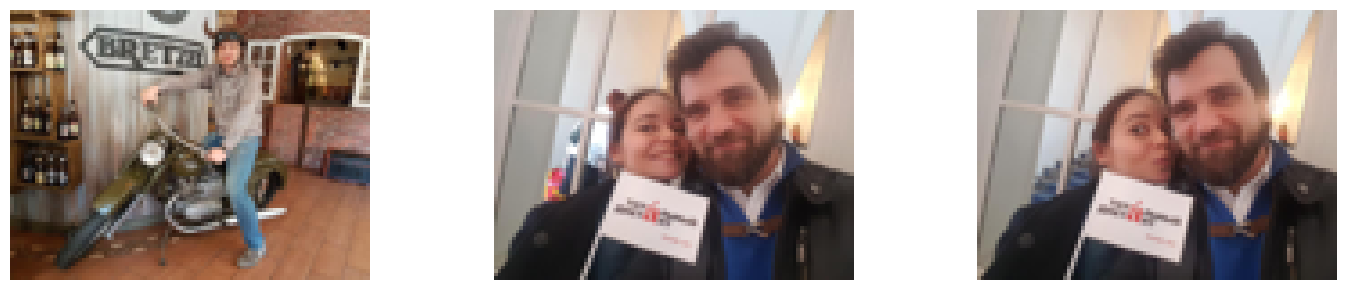

Cluster 1 contains 3 images.


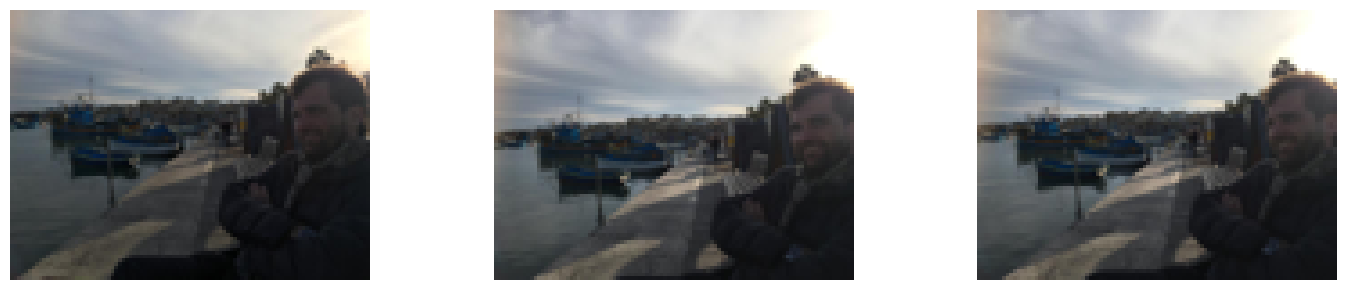

In [22]:
def extract_pyramid_features(img_path, model, levels=[1, 2, 4]):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    features = []
    for level in levels:
        scale = 224 // level
        for y in range(level):
            for x in range(level):
                # Изменение размера и обрезка для создания пирамиды
                resized_img = image.smart_resize(img_array, (scale * level, scale * level))
                cropped_img = resized_img[:, y * scale : (y + 1) * scale, x * scale : (x + 1) * scale, :]
                # Извлечение признаков
                feature = model.predict(cropped_img).flatten()
                features.append(feature)

    # Объединение признаков со всех уровней
    final_features = np.concatenate(features)
    return final_features


# Загрузка предварительно обученной модели
model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# Извлечение признаков из всех изображений в папке
features_list, images_paths = get_features_from_folder(folder_path)

# Квантование признаков
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features_list)

# Находим индекс центроида для каждого изображения
labels = kmeans.labels_

# Группировка изображений по кластерам
clustered_images = {}
for i, label in enumerate(labels):
    clustered_images.setdefault(label, []).append(images_paths[i])

# Отображаем изображения по кластерам
display_clustered_images(clustered_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━

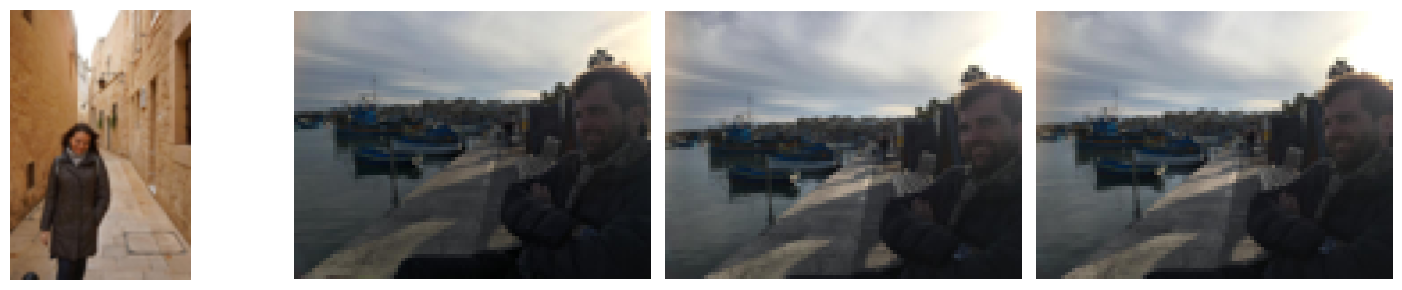

Cluster 3 contains 1 images.


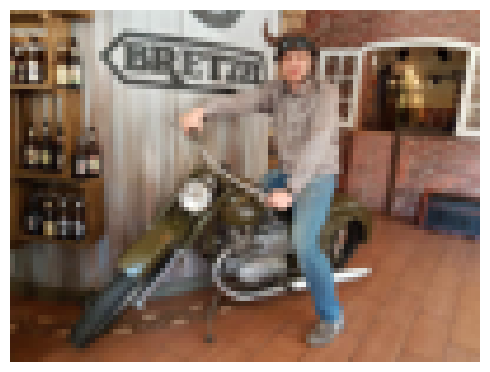

Cluster 2 contains 2 images.


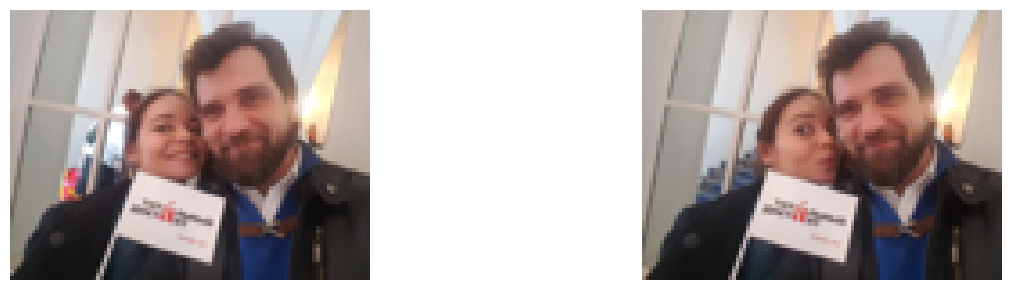

Cluster 0 contains 1 images.


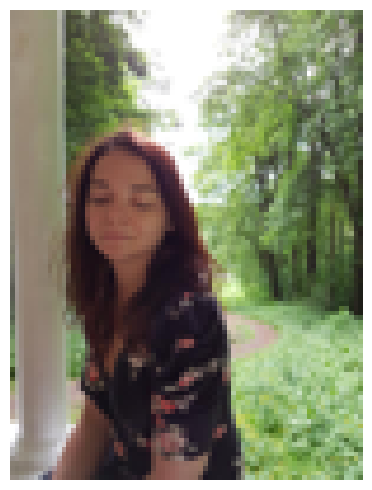

In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans

# Загрузка предварительно обученной модели ResNet50 без верхнего слоя
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
model = Model(inputs=base_model.input, outputs=base_model.output)


def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    return features.flatten()


def extract_pyramid_features(img_path, model, levels=[1, 2, 4]):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)

    features = []
    for level in levels:
        level_features = []
        step_size = 224 // level
        for y in range(level):
            for x in range(level):
                crop = preprocessed_img[:, y * step_size : (y + 1) * step_size, x * step_size : (x + 1) * step_size, :]
                crop_features = model.predict(crop).flatten()
                level_features.append(crop_features)
        features.extend(level_features)
    return np.concatenate(features)


def get_features_from_folder(folder_path):
    features_list = []
    images_paths = []
    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith(("png", "jpg", "jpeg")):
            img_path = os.path.join(folder_path, img_name)
            features = extract_pyramid_features(img_path, model)
            features_list.append(features)
            images_paths.append(img_path)
    return features_list, images_paths


# Извлекаем признаки из всех изображений в папке
script_dir = os.getcwd()
folder_path = os.path.join(script_dir, "/content/image_processing/data/plibrary/justfaces")
features_list, images_paths = get_features_from_folder(folder_path)

# Применяем K-средние для квантования признаков
num_clusters = 4  # Примерное количество ожидаемых групп
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features_list)

# Находим индекс центроида для каждого изображения
labels = kmeans.labels_

# Группировка изображений по кластерам
clustered_images = {}
for i, label in enumerate(labels):
    clustered_images.setdefault(label, []).append(images_paths[i])


def display_clustered_images(clustered_images, images_per_row=5):
    for cluster_id, images in clustered_images.items():
        print(f"Cluster {cluster_id} contains {len(images)} images.")
        num_rows = int(np.ceil(len(images) / images_per_row))
        num_cols = min(images_per_row, len(images))

        if len(images) == 1:
            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
            axs = np.array([[axs]])  # Обеспечиваем 2D массив для единообразия
        else:
            fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3 * num_rows))
            axs = np.atleast_2d(axs)  # Убеждаемся, что axs всегда 2D массив

        # Преобразуем axs в 1D массив для упрощения итерации
        axs_flat = axs.ravel()

        for ax, img_path in zip(axs_flat, images):
            thumbnail = create_thumbnail(img_path)
            ax.imshow(thumbnail)
            ax.axis("off")

        # Скрываем пустые ячейки
        for ax in axs_flat[len(images) :]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()


# Вывод результатов группировки
display_clustered_images(clustered_images)

# Работа с векторной БД


In [ ]:
from annoy import AnnoyIndex
import numpy as np

# Предполагаем, что extract_pyramid_features и model уже определены
feature_dim = 43008  # Задайте размерность вашего вектора признаков
index = AnnoyIndex(feature_dim, "euclidean")  # Используем Евклидово расстояние

features_list, images_paths = get_features_from_folder(folder_path)
for i, features in enumerate(features_list):
    index.add_item(i, features)

index.build(10)  # 10 деревьев
index.save("./data/image_features.ann")

1/1 [==============================] - 0s 58ms/step


True

1/1 [==============================] - 0s 61ms/step
['c:\\git\\image_processing\\./data/plibrary/justfaces\\img_06.jpg', 'c:\\git\\image_processing\\./data/plibrary/justfaces\\img_24.jpg', 'c:\\git\\image_processing\\./data/plibrary/justfaces\\img_22.jpg', 'c:\\git\\image_processing\\./data/plibrary/justfaces\\img_23.jpg', 'c:\\git\\image_processing\\./data/plibrary/justfaces\\img_16.jpg']


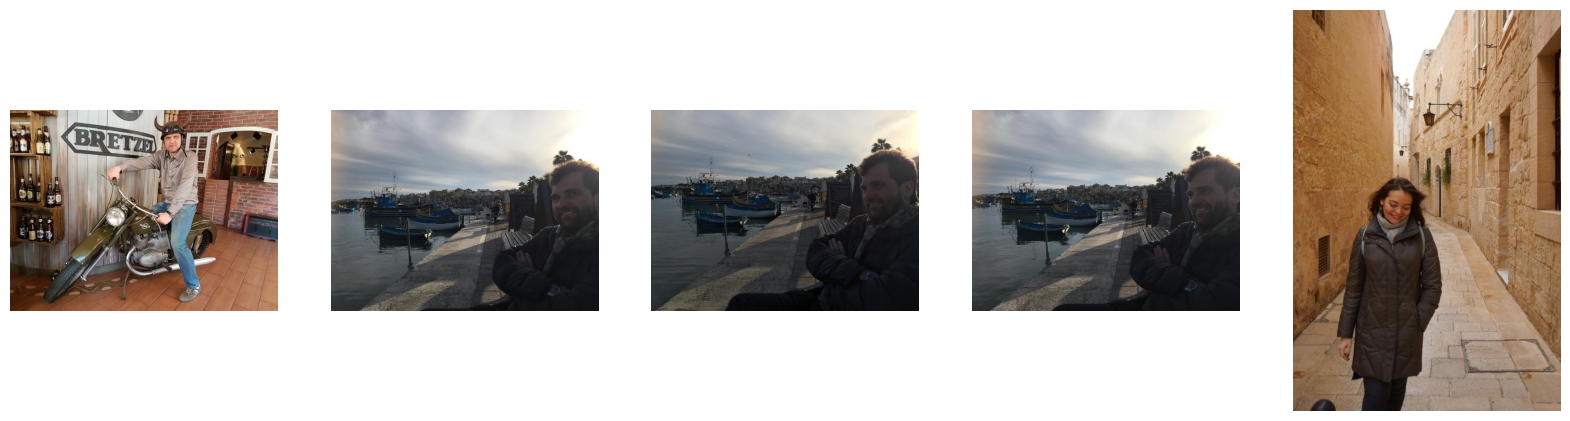

In [ ]:
# Загрузка индекса
index = AnnoyIndex(feature_dim, "euclidean")
index.load("./data/image_features.ann")

# Извлечение признаков для целевого изображения
target_features = extract_pyramid_features("./data/plibrary/justfaces/img_06.jpg", model)

# Поиск ближайших соседей
nearest_ids = index.get_nns_by_vector(target_features, 5)  # Ищем 5 ближайших соседей

# Получение путей к ближайшим изображениям
nearest_image_paths = [images_paths[i] for i in nearest_ids]

print(nearest_image_paths)
from PIL import Image
import matplotlib.pyplot as plt


def display_images(image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 10))
    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
    plt.show()


display_images(nearest_image_paths)